# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Метод k-средних, предобработка признаков


###### <hr\>
**Общая информация**

**Срок сдачи:** 28 ноября 2018, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 28 ноября, -4 балла после 06:00 5 декабря, -6 баллов после 06:00 12 декабря, -8 баллов после 19 декабря

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush

Необходимо в slack создать таск в приватный чат:
/todo Фамилия Имя ссылка на гитхаб @alkhamush
Пример:
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush
Дополнительно нужно просто скинуть ссылку в slack в личный чат

Используйте данный Ipython Notebook при оформлении домашнего задания.

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.  
При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

###### Задание 1 (2 баллов)
Имплементируйте метод k-means. Задание считается выполненным, если Ваша реализация работает быстрее реализации из sklearn.

Теория для выполнения задания 2 и 3 остаётся на самостоятельное изучение. Теории немного и она совсем простая.

###### Задание 2 (2 балла)
Имплементируйте класс MiniBatchKMeans, который является классом наследником Kmeans.

###### Задание 3 (2 балла)
Превратите k-means в k-means++. Для этого нужно реализовать метод в классе Kmeans, который будет инициализировать более "хорошие" значения центроидов. Чтобы использовался метод k-means++, в параметр init необходимо передать строковое значение 'k-means' (по умолчанию 'random').

###### Задание 4 (2 балла)
В пункте "Проверка корректности метода" нужно нарисовать графики, которые показывают зависимость времени выполнения алгоритма от количества сэмплов. Графики должны быть  нарисованы для различных комбинаций реализаций алгоритма (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). График достаточно построить на 5-10 точках.

###### Задание 5 (2 балла)
В пункте "Применение K-means на реальных данных" нужно сравнить различные реализации k-means (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). После чего написать вывод, в котором должно быть объяснение того, почему один алгоритм оказался лучше остальных или почему не было выявлено лучшего алгоритма.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл
<hr\>

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from sklearn.metrics.pairwise import pairwise_distances
import time
from sklearn.cluster import KMeans

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

%load_ext pycodestyle_magic

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


In [93]:
#%%pycodestyle


class MyKmeans:

    def __init__(self, k=2, metric='euclidean',
                 max_iter=1000, random_state=None, init='random'):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """

        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        self.init = init
        self.eps = 1e-6

    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """

        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)

        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0])

        # Массив с центройдами кластеров
        self.centroids = np.empty((self.k, X.shape[1]))

        # Init
        self.centroids = self.init_centroids(X)

        new_centroids = deepcopy(self.centroids)

        for _ in range(self.max_iter):
            dists = pairwise_distances(X, self.centroids)             
            self.labels = np.argmin(dists, axis=1) 
            
            if np.bincount(self.labels, minlength=self.k).min() == 0:
                # Bad assumption - reinit
                self.centroids = self.init_centroids(X)
                continue
                
            # Update centroids
            for i in range(self.k):                
                new_centroids[i] = np.mean(X[self.labels == i], axis=0)
            
            # Convergence condition
            if np.linalg.norm(new_centroids - self.centroids) < self.eps:
                break
                
            self.centroids = deepcopy(new_centroids)

        return self
    
    def init_centroids(self, X):
        if self.init == 'random':
            mean = np.mean(X, axis=0)
            std = np.std(X, axis=0)
            return np.random.rand(self.k, X.shape[1]) * std + mean
        else:
            return self.init_kmpp(X)

    def init_kmpp(self, X):
        centroids = np.empty((self.k, X.shape[1]))
        centroids[0] = X[np.random.choice(X.shape[0])]
        for i in range(1, self.k):
            dists = pairwise_distances(X, centroids[:i, :])
            mindist = dists.min(axis=1)
            weight = mindist / mindist.sum()
            centroids[i] = X[np.random.choice(X.shape[0], p=weight)]
        return centroids

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера


        Возвращает метку ближайшего кластера для каждого объекта
        """


class MiniBatchKMeans(MyKmeans):
    def __init__(self, k=2, metric='euclidean', 
                 max_iter=1000, random_state=None,
                 init='random', butch_size=10):
        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        self.init = init
        self.butch_size = butch_size
        self.eps = 1e-3
        
    def fit(self, X, y=None):
        np.random.seed(self.random_state)
        self.labels = np.empty(X.shape[0])
        self.centroids = np.empty((self.k, X.shape[1]))
        self.centroids = self.init_centroids(X)
        new_centroids = deepcopy(self.centroids)        
        for _ in range(self.max_iter):
            mask = np.random.choice(np.arange(X.shape[0]), self.butch_size)
            M = X[mask]
            dists = pairwise_distances(M, self.centroids)
            self.labels[mask] = np.argmin(dists, axis=1)
            for i in range(self.k):
                # Move center if we know smth about cluster
                if len(self.labels[self.labels == i]) > 0:
                    new_centroids[i] = np.mean(X[self.labels == i], axis=0)
            if np.linalg.norm(new_centroids - self.centroids) < self.eps:
                break                
            self.centroids = deepcopy(new_centroids)
        dists = pairwise_distances(X, self.centroids)
        self.labels = np.argmin(dists, axis=1)
        return self

### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, нужно испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [4]:
from sklearn.datasets import make_blobs

In [95]:
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

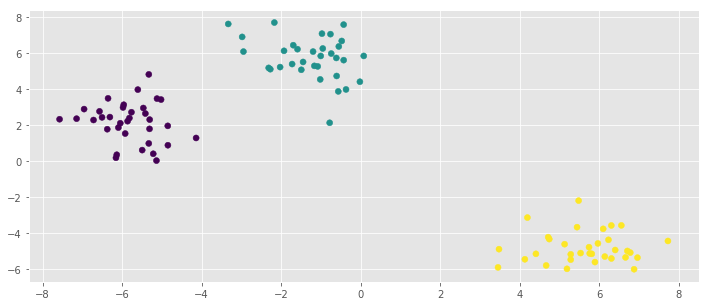

In [96]:
plt.scatter(X[:,0], X[:, 1], c=y)

Проверьте Вашу имплементацию на простых данных (без этого пункта ДЗ не считается выполненным).   
КОММЕНТАРИИ НЕ СТИРАТЬ!

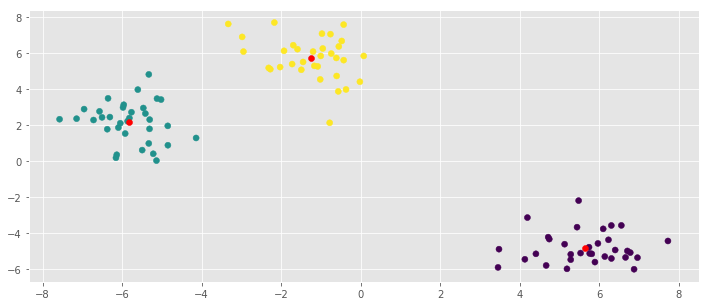

In [97]:
## Работоспособность MyKmeans
my_cls = MyKmeans(k=3)
my_cls.fit(X)
plt.scatter(X[:,0], X[:,1], c=my_cls.labels)
plt.scatter(my_cls.centroids[:,0], my_cls.centroids[:,1], c='red')

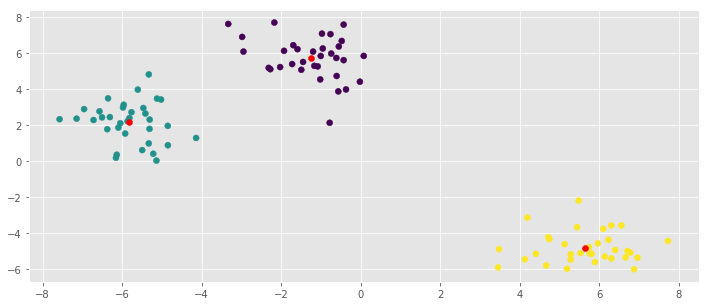

In [98]:
## Работоспособность MyKmeans++
my_cls = MyKmeans(k=3, init='k-means')
my_cls.fit(X)
plt.scatter(X[:,0], X[:,1], c=my_cls.labels)
plt.scatter(my_cls.centroids[:,0], my_cls.centroids[:,1], c='red')

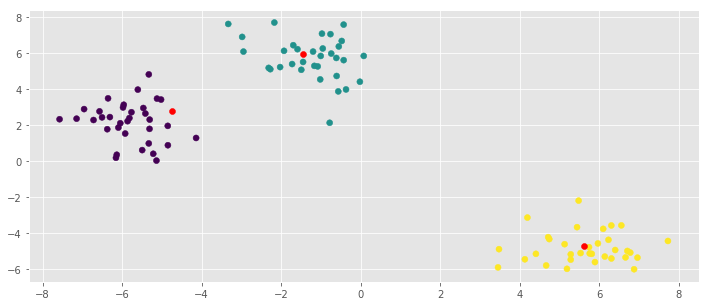

In [100]:
## Работоспособность MyKmeans с MiniBatchMyKmeans
my_cls = MiniBatchKMeans(k=3, init='random')
my_cls.fit(X)
plt.scatter(X[:,0], X[:,1], c=my_cls.labels)
plt.scatter(my_cls.centroids[:,0], my_cls.centroids[:,1], c='red')

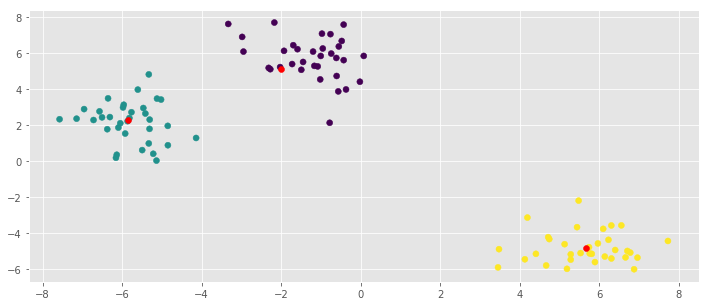

In [101]:
## Работоспособность MyKmeans++ с MiniBatchMyKmeans
my_cls = MiniBatchKMeans(k=3, init='k-means')
my_cls.fit(X)
plt.scatter(X[:,0], X[:,1], c=my_cls.labels)
plt.scatter(my_cls.centroids[:,0], my_cls.centroids[:,1], c='red')

0.03768813610076904


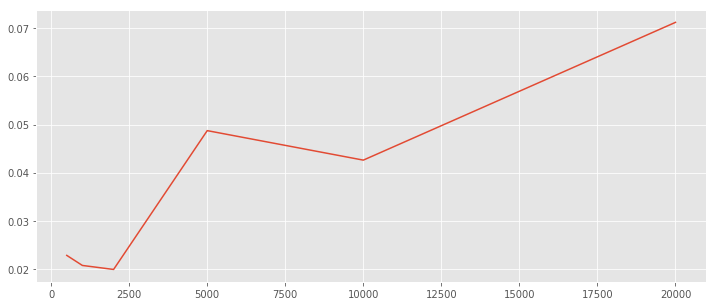

In [102]:
## Время выполнения алгоритма Kmeans из sklearn
samples = [500, 1000, 2000, 5000, 10000, 20000]
t1 = []
for s in samples:
    X, y = make_blobs(n_samples=s, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    clf = KMeans(n_clusters=3)
    tau = time.time()
    clf.fit(X)
    t1.append(time.time() - tau)
print(np.mean(t1))
plt.plot(samples, t1)

0.009438912073771158


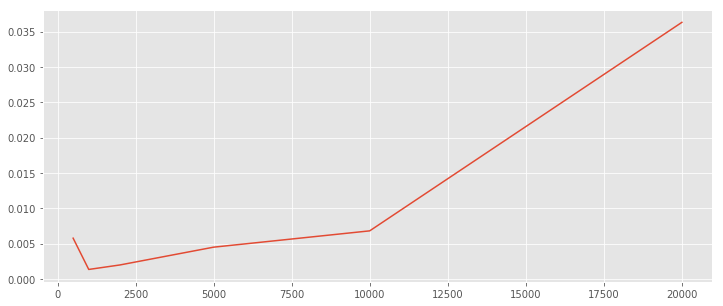

In [103]:
## Время выполнения алгоритма MyKmeans
samples = [500, 1000, 2000, 5000, 10000, 20000]
t2 = []
for s in samples:
    X, y = make_blobs(n_samples=s, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    clf = MyKmeans(k=3, max_iter=300)
    tau = time.time()
    clf.fit(X)
    t2.append(time.time() - tau)
print(np.mean(t2))
plt.plot(samples, t2)

0.009351015090942383


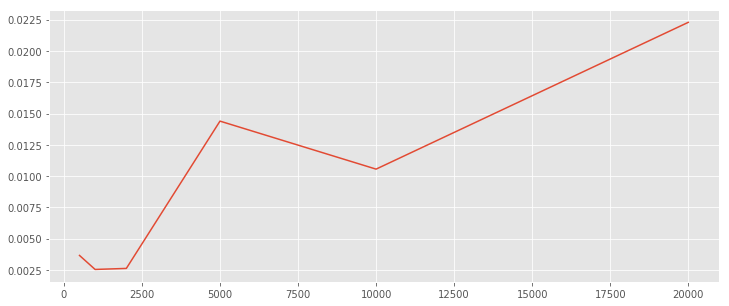

In [104]:
## Время выполнения алгоритма MyKmeans++
samples = [500, 1000, 2000, 5000, 10000, 20000]
t3 = []
for s in samples:
    X, y = make_blobs(n_samples=s, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    clf = MyKmeans(k=3, max_iter=300, init='k-means')
    tau = time.time()
    clf.fit(X)
    t3.append(time.time() - tau)
print(np.mean(t3))
plt.plot(samples, t3)

0.05355823040008545


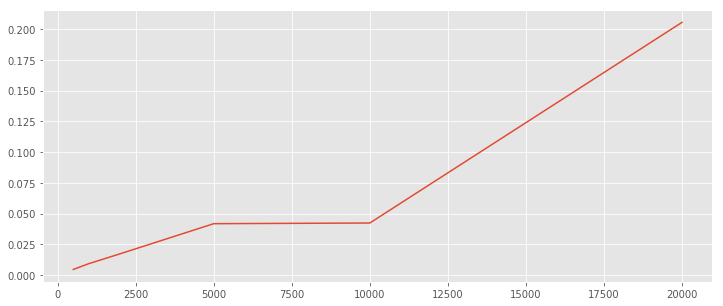

In [118]:
## Время выполнения алгоритма MyKmeans с MiniBatchMyKmeans
samples = [500, 1000, 2000, 5000, 10000, 20000]
t4 = []
for s in samples:
    X, y = make_blobs(n_samples=s, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    clf = MiniBatchKMeans(k=3, max_iter=300, butch_size=500)
    tau = time.time()
    clf.fit(X)
    t4.append(time.time() - tau)
print(np.mean(t4))
plt.plot(samples, t4)

0.10090327262878418


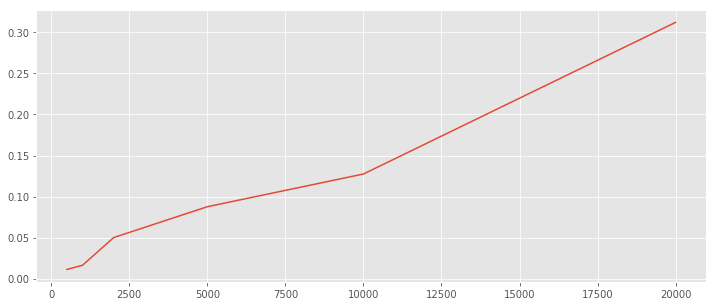

In [119]:
## Время выполнения алгоритма  MyKmeans++ с MiniBatchMyKmeans
samples = [500, 1000, 2000, 5000, 10000, 20000]
t5 = []
for s in samples:
    X, y = make_blobs(n_samples=s, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    clf = MiniBatchKMeans(k=3, max_iter=300, butch_size=100, init='k-means')
    tau = time.time()
    clf.fit(X)
    t5.append(time.time() - tau)
print(np.mean(t5))
plt.plot(samples, t5)

# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.  (без этого пункта задание не считается выполненным).   
ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [123]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns.head()

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006,NaN,18.995,10,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [124]:
df_sns = df_sns.drop(['gradyear', 'gender', 'age', 'friends'], axis=1)
X = df_sns.values
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
words = df_sns.columns

In [126]:
## MyKMeans
clf = MyKmeans(k=10)
%time clf.fit(X)
for i, centr in enumerate(clf.centroids):
    print(words[np.argsort(centr)[-5:]], clf.labels[clf.labels == i].size)

CPU times: user 1.72 s, sys: 1.35 s, total: 3.07 s
Wall time: 812 ms
Index(['hair', 'cute', 'shopping', 'dance', 'dress'], dtype='object') 1672
Index(['hot', 'cute', 'football', 'shopping', 'cheerleading'], dtype='object') 621
Index(['rock', 'sports', 'basketball', 'football', 'baseball'], dtype='object') 517
Index(['death', 'bible', 'jesus', 'tennis', 'blonde'], dtype='object') 19070
Index(['clothes', 'mall', 'shopping', 'abercrombie', 'hollister'], dtype='object') 810
Index(['dance', 'mall', 'band', 'cute', 'shopping'], dtype='object') 4363
Index(['death', 'church', 'god', 'jesus', 'bible'], dtype='object') 371
Index(['drunk', 'sex', 'hair', 'drugs', 'kissed'], dtype='object') 855
Index(['basketball', 'football', 'shopping', 'sports', 'soccer'], dtype='object') 679
Index(['football', 'sports', 'basketball', 'volleyball', 'softball'], dtype='object') 1042


In [127]:
## MyKMeans++
clf = MyKmeans(k=10, init='k-means')
%time clf.fit(X)
for i, centr in enumerate(clf.centroids):
    print(words[np.argsort(centr)[-5:]], clf.labels[clf.labels == i].size)

CPU times: user 2.24 s, sys: 1.79 s, total: 4.03 s
Wall time: 1.05 s
Index(['football', 'rock', 'music', 'band', 'marching'], dtype='object') 572
Index(['sex', 'die', 'hair', 'drugs', 'drunk'], dtype='object') 683
Index(['dress', 'dance', 'mall', 'cute', 'shopping'], dtype='object') 3941
Index(['music', 'god', 'rock', 'die', 'death'], dtype='object') 989
Index(['clothes', 'mall', 'shopping', 'abercrombie', 'hollister'], dtype='object') 838
Index(['sex', 'swimming', 'jesus', 'tennis', 'blonde'], dtype='object') 19019
Index(['soccer', 'sports', 'baseball', 'basketball', 'football'], dtype='object') 2464
Index(['music', 'church', 'god', 'jesus', 'bible'], dtype='object') 496
Index(['shopping', 'sports', 'volleyball', 'basketball', 'softball'], dtype='object') 502
Index(['clothes', 'drugs', 'hair', 'sex', 'kissed'], dtype='object') 496


In [132]:
## MyKMeans с MiniBatchMyKMeans
clf = MiniBatchKMeans(k=10, butch_size=200)
%time clf.fit(X)
for i, centr in enumerate(clf.centroids):
    print(words[np.argsort(centr)[-5:]], clf.labels[clf.labels == i].size)

CPU times: user 1.33 s, sys: 7.68 ms, total: 1.34 s
Wall time: 1.33 s
Index(['football', 'rock', 'music', 'band', 'marching'], dtype='object') 570
Index(['soccer', 'god', 'jesus', 'bible', 'church'], dtype='object') 1230
Index(['bible', 'swimming', 'soccer', 'tennis', 'blonde'], dtype='object') 18379
Index(['kissed', 'death', 'hair', 'sex', 'drunk'], dtype='object') 362
Index(['volleyball', 'softball', 'baseball', 'football', 'basketball'], dtype='object') 2158
Index(['music', 'rock', 'god', 'die', 'death'], dtype='object') 1772
Index(['die', 'sex', 'hair', 'drugs', 'kissed'], dtype='object') 782
Index(['hair', 'sex', 'hot', 'cute', 'sexy'], dtype='object') 531
Index(['clothes', 'mall', 'shopping', 'abercrombie', 'hollister'], dtype='object') 839
Index(['dance', 'dress', 'mall', 'cute', 'shopping'], dtype='object') 3377


In [133]:
## MyKMeans++ с MiniBatchMyKMeans
clf = MiniBatchKMeans(k=10, butch_size=200, init='k-means')
%time clf.fit(X)
for i, centr in enumerate(clf.centroids):
    print(words[np.argsort(centr)[-5:]], clf.labels[clf.labels == i].size)

CPU times: user 669 ms, sys: 345 ms, total: 1.01 s
Wall time: 561 ms
Index(['football', 'rock', 'music', 'band', 'marching'], dtype='object') 572
Index(['soccer', 'god', 'jesus', 'bible', 'church'], dtype='object') 1164
Index(['bible', 'swimming', 'soccer', 'tennis', 'blonde'], dtype='object') 18398
Index(['kissed', 'death', 'hair', 'sex', 'drunk'], dtype='object') 361
Index(['volleyball', 'softball', 'baseball', 'football', 'basketball'], dtype='object') 2150
Index(['music', 'rock', 'god', 'die', 'death'], dtype='object') 1771
Index(['die', 'sex', 'hair', 'drugs', 'kissed'], dtype='object') 781
Index(['hair', 'sex', 'hot', 'cute', 'sexy'], dtype='object') 537
Index(['clothes', 'mall', 'shopping', 'abercrombie', 'hollister'], dtype='object') 839
Index(['dance', 'dress', 'mall', 'cute', 'shopping'], dtype='object') 3427


## Вывод
Обычный k-means без батчей оказался быстрее k-mean++, так как не было больших вычислительных затрат на инициализацию центров кластеров. У обычной мини-батч версии очень большая дисперсия по времени, так как в начальном приближении может сильно неповезти, и так как центры мы не перекидываем, то будем медленно двигаться к хорошим позициям, но может и сильно повезти. Мини-батч с k-mean++ взлетел из-за того, что мы сразу выбрали достаточно хорошие приближения, а потом из-за размера данных батч версия обогнала обычную.